# DS 3000 Project: Goodreads Book Recommendation System
## Madeleine Jin, Melina Yang, Shru Kumar, Grace Pietak

# Abstract
This project aims to create a book recommendation system for books solely within a user's pre-made shelf or list. We collected data from the Goodreads website using our own premade reading list by extracting information about each individual book (ie. title, author, genres, rating, etc). Given this information, our program outputs a recommended book or list of books from their list. In order to do this, we calculated pairwise similarity scores and then used k-means clustering. Additionally, we have functions with an option to search purely by genre and keyword if desired. The versatility of our code functionality allows the user to modify their desired book characteristics and number of books to recommend.


# Introduction
For many readers, deciding what book to read next can be a difficult task, especially with the overwhelming number of options available both in print and digitally. Goodreads is one of the largest cataloging websites for books that allows users to explore new books, search for books, review books they have read or are interested in reading, etc. One of the most popular features of the website is the ability to create virtual bookshelves or lists to keep track of books to read with ease. Overtime, many of these lists can grow and choosing a book can become very overwhelming. Goodreads already has a recommendation feature, however this system often recommends brand new books for readers to buy and read, ignoring the ones already in user’s pre-existing lists. By suggesting books within a user's pre-existing list, we hope to counteract excessive consumerism and wasteful behaviors. By examining different factors of a book a user has input and enjoyed, we are able to output a list of most similar books within their bookshelf. To start, we created a reading list on the Goodreads website and scraped relevant data about each of the individual books to add to our model using Beautiful Soup. Our framework is based on pairwise similarity scores from the book the user input and k-means clustering; however, there are also two more options to search a given list by genre or keyword as well. An sample image of a Goodreads reading list can be found below:


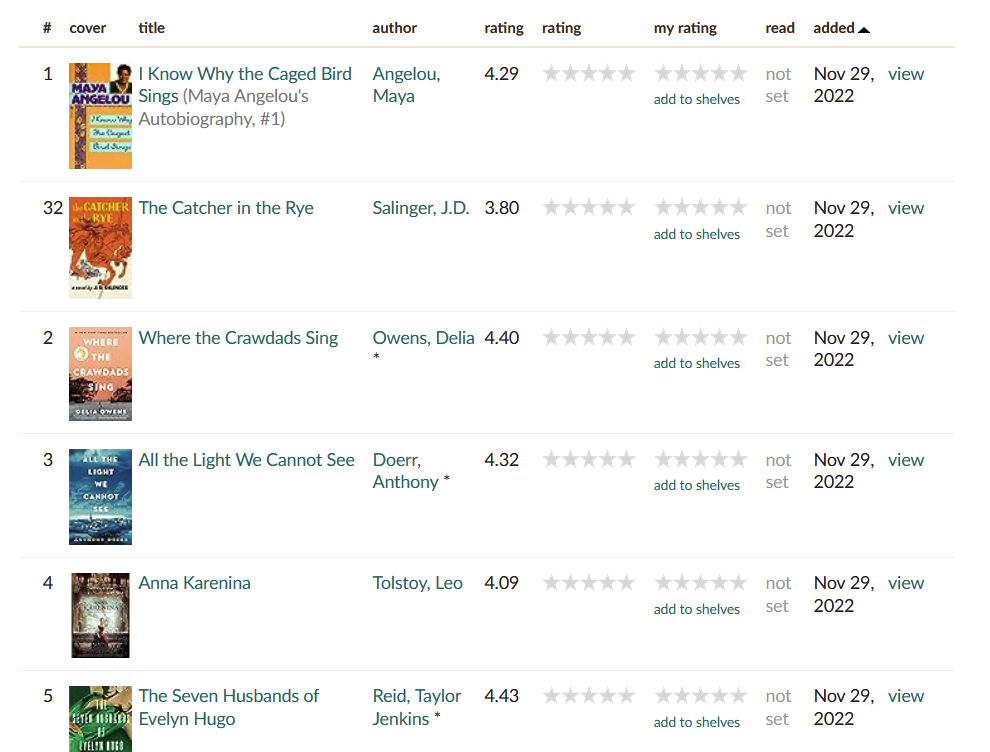

# Data Description

Our project contains data from each individual book on a premade Goodreads reading list. Given the url to the users book list, our code retrieves information about each individual book storing them all into a dataframe. We used the BeautifulSoup library to web scrape each book’s titles, authors, genres, descriptions, book URLs, ratings, number of ratings, and number of reviews. The web scraping functions can be found below along with the first few rows of the created dataframe.

# Pipeline Overview
## Web Scraping/Functions

In [1]:
# Imports
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
sns.set()

### Scraping the Bookshelf / Reading List
`scrape_shelf()`
- This is the main function responsible for scraping the Goodreads reading list from the website. All information that was scraped is stored into and returned as a dataframe.

In [2]:
def scrape_shelf(url):
    """
    Scrapes GoodReads shelf using Beautiful Soup for book information (ex. title, author, genre) and stores in a pandas dataframe

    Arguments:
        url (str): link to list of books
    Returns:
    	df_books (pd.DataFrame): df holding books in shelf and associated info
    """
    # Gets soup from given url
    str_html = requests.get(url).text
    soup = BeautifulSoup(str_html)
    soup_class = soup.find_all(class_="js-tooltipTrigger tooltipTrigger")
    
    # Creates empty lists
    titles = []
    authors = []
    blurbs = []
    genres = []
    book_urls = []
    book_ratings = []
    num_ratings = []
    num_reviews = []

    # Adds each individual book's URL into book_urls list
    for book_soup in soup_class:

        # Extract each url and append the book's URL to the book_urls list
        a_tag = book_soup.find('a')
        book_link = a_tag['href']
        shelf_link = f'https://www.goodreads.com{book_link}'
        book_urls.append(shelf_link)

    # Iterate through each book's URL in book_urls
    for book_link in book_urls:

        # Parse the HTML content using BeautifulSoup
        str_html = requests.get(book_link).text
        soup = BeautifulSoup(str_html)
        
        # Titles
        title = soup.find_all(class_="Text Text__title1")[0].text
        titles.append(title)
        
        # Ratings
        rating = soup.find_all(class_="RatingStatistics__rating")[1].text
        book_ratings.append(float(rating))
        
        # Number of ratings
        ratings_reviews = soup.find_all(class_="RatingStatistics__meta")[1].text
        ratings_count = ratings_reviews.split()[0].replace(',','')
        num_ratings.append(int(ratings_count))

        # Number of reviews
        reviews_count = ratings_reviews.split()[1].split('s')[1].replace(',','')
        num_reviews.append(int(reviews_count))
        
        # Authors
        author = soup.find_all(class_="ContributorLink__name")[0].text
        authors.append(author)
        
        # Genres
        genre = soup.find_all('div', {'class': "BookPageMetadataSection__genres"})
        genre = genre[0]
        ul_tag = soup.find('ul', class_='CollapsableList')
        genre_spans = ul_tag.find_all('span', class_='Button__labelItem')
        new_genre = [span.text for span in genre_spans]
        new_genre = new_genre[:-1]
        genres.append(new_genre)
        
        # Blurbs
        blurb = soup.find_all(class_="Formatted")[0].text
        blurbs.append(blurb)
    
    # Put into dictionary
    books_dict = {'Titles': titles, 
                  'Authors': authors, 
                  'Genres': genres,
                  'Blurbs': blurbs,
                  'Book URLs': book_urls, 
                  'Book Ratings': book_ratings,
                  'Num Ratings': num_ratings, 
                  'Num Reviews': num_reviews}
    
    # Convert to dataframe and return it
    df = pd.DataFrame(books_dict)
    return df

In [3]:
# Call scrape_shelf function and store dataframe in 'df'
df = scrape_shelf('https://www.goodreads.com/review/list/158906936-madeleine-jin?order=a&shelf=to-read&sort=position')
df.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews
0,I Know Why the Caged Bird Sings,Maya Angelou,"[Nonfiction, Classics, Memoir, Biography, Auto...",Maya Angelou’s debut memoir is a modern Americ...,https://www.goodreads.com/book/show/13214.I_Kn...,4.29,522332,15819
1,The Catcher in the Rye,J.D. Salinger,"[Classics, Fiction, Young Adult, Literature, S...",It's Christmas time and Holden Caulfield has j...,https://www.goodreads.com/book/show/5107.The_C...,3.80,3460521,82632
2,Where the Crawdads Sing,Delia Owens,"[Fiction, Historical Fiction, Mystery, Romance...","For years, rumors of the “Marsh Girl” haunted ...",https://www.goodreads.com/book/show/36809135-w...,4.39,2862062,198520
3,All the Light We Cannot See,Anthony Doerr,"[Historical Fiction, Fiction, Historical, War,...",Marie-Laure lives in Paris near the Museum of ...,https://www.goodreads.com/book/show/18143977-a...,4.32,1589639,102765
4,Anna Karenina,Leo Tolstoy,"[Classics, Fiction, Romance, Russia, Historica...",Acclaimed by many as the world's greatest nove...,https://www.goodreads.com/book/show/15823480-a...,4.09,833448,34310


## Method

With the information we collected, we decided to create a few different ways for our recommendation system to work. A user is able to search by either genre or keyword and be presented with the books that match sorted by the number of reviews and ratings. If a user doesn't know what they would like to read they can also input a book they enjoyed and recommend similar ones on their reading list. This system is based on cosine similarity and K-means clustering. The cosine similarity calculates similarity scores based on the books genres and descriptions. We found this to be the best way to compare these since some books belonged to multiple genres. From there we extracted and scaled all the numeric features we collected and preformed K-means clustering. With this method the rating and popularity of the books are also taken into account. 



### Recommendation by Genre
`recommendation_by_genre()`
- This function allows a user to look through a specific genre of books that are on their reading list

In [4]:
def recommendation_by_genre(df, genre, count=5):
    """ 
    Recommends books based on genre given by the user.

    Arguments:
       df (pd.DataFrame): DataFrame containing book information.
       genre (str): Genre the user wants to read.
       count (int): Number of recommended books. Default is 5.
       
    Returns:
        df_recommended (pd.DataFrame): DataFrame containing recommended books.
    """
    # Filter rows based on genre
    filtered_rows = []
    for index, row in df.iterrows():
        if genre in row['Genres']:
            filtered_rows.append(row)

    # Create DataFrame 'df_recommended' with filtered rows
    df_recommended = pd.DataFrame(filtered_rows, columns=df.columns)

    # Sort by 'Num Reviews' and 'Num Ratings'
    df_recommended = df_recommended.sort_values(by=['Num Reviews', 'Num Ratings'], ascending=False)
    df_recommended = df_recommended.reset_index(drop=True)

    # Finished DataFrame with recommended books
    return df_recommended.head(count)

In [5]:
df_recommended_genre = recommendation_by_genre(df=df, genre='Memoir', count=5)
df_recommended_genre.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews
0,Spare,Prince Harry,"[Nonfiction, Memoir, Audiobook, Biography, Aut...",It was one of the most searing images of the t...,https://www.goodreads.com/book/show/62296528-s...,3.87,322502,36550
1,I Know Why the Caged Bird Sings,Maya Angelou,"[Nonfiction, Classics, Memoir, Biography, Auto...",Maya Angelou’s debut memoir is a modern Americ...,https://www.goodreads.com/book/show/13214.I_Kn...,4.29,522332,15819
2,"Why Fish Don't Exist: A Story of Loss, Love, a...",Lulu Miller,"[Nonfiction, Science, Memoir, History, Biograp...",A wondrous debut from an extraordinary new voi...,https://www.goodreads.com/book/show/50887097-w...,4.17,36339,5698


### Recommendation by Keyword
`recommendation_by_keyword()`
- This function searches through book descriptions and looks for a specific keyword to present books to recommend

In [6]:
def recommendation_by_keyword(df, keyword, count=1):
    """
    Recommends books that have the specified keyword within their reviews.
    
    Arguments:
        df (pd.DataFrame): DataFrame containing book information.
        keyword (str): Keyword the user wants to read about.
        count (int): Number of recommended books (default is 1).
    Returns:
        df_recommended (pd.DataFrame): DataFrame containing recommended books and associated information.
    """
    # Filter rows based on keyword
    filtered_rows = []
    for index, row in df.iterrows():
        if keyword.lower() in row['Blurbs']:
            filtered_rows.append(row)

    # Create DataFrame 'df_recommended' with filtered rows
    df_recommended = pd.DataFrame(filtered_rows, columns=df.columns)
    df_recommended = df_recommended.reset_index(drop=True)

    return df_recommended.head(count)

In [7]:
df_recommended_keyword = recommendation_by_keyword(df=df, keyword='Memoir', count=1)
df_recommended_keyword.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews
0,I Know Why the Caged Bird Sings,Maya Angelou,"[Nonfiction, Classics, Memoir, Biography, Auto...",Maya Angelou’s debut memoir is a modern Americ...,https://www.goodreads.com/book/show/13214.I_Kn...,4.29,522332,15819


### Similarity Scores
`get_sim_scores()`
- This function uses cosine similarity to calculate a similarity score between books based on genres and book descriptions

In [8]:
def get_sim_scores(df, title):
    """
    Calculate similarity scores based on genres and blurbs.

    Parameters:
        df (pandas DataFrame): DataFrame containing books.
        title (string): Book title to calculate similarity scores.

    Returns:
        df (pandas DataFrame): Updated DataFrame with added 'sim_scores' column.
    """
    # Genres formatted for count vector
    df['str_genres'] = [','.join(map(str, l)) for l in df['Genres']]
    
    # Count vectorizer for genres
    count = CountVectorizer(stop_words='english')
    count_matrix = count.fit_transform(df['str_genres'])
    
    # Returning df back to original
    df.drop(columns = ['str_genres'], inplace = True)
    
    # TF-IDF Vectorizer removes stop words and fits and transforms the data
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['Blurbs'])
        
    # Maps indexes
    df = df.reset_index(drop=True)
    indices = pd.Series(df.index, index=df['Titles'])
    idx = indices[title]

    # Compute the cosine similarity matrix using linear kernel and sort books based on scores
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    genre_sim_scores = list(enumerate(cosine_sim[idx]))

    # Compute the cosine similarity matrix using linear kernel and sort books based on scores
    cosine_sim2 = linear_kernel(tfidf_matrix, tfidf_matrix)    
    blurb_sim_scores = list(enumerate(cosine_sim2[idx]))    
    
    # Simalarity scores for genre and blurb
    sim_scores = []
    for i in range(len(genre_sim_scores)):
        sim_scores.append(genre_sim_scores[i][1] + blurb_sim_scores[i][1])
    df['sim_scores'] = sim_scores

    # Finished DataFrame with recommended books
    return df

In [9]:
df_sim_score = get_sim_scores(df=df, title='Spare')
df_sim_score.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews,sim_scores
0,I Know Why the Caged Bird Sings,Maya Angelou,"[Nonfiction, Classics, Memoir, Biography, Auto...",Maya Angelou’s debut memoir is a modern Americ...,https://www.goodreads.com/book/show/13214.I_Kn...,4.29,522332,15819,0.698625
1,The Catcher in the Rye,J.D. Salinger,"[Classics, Fiction, Young Adult, Literature, S...",It's Christmas time and Holden Caulfield has j...,https://www.goodreads.com/book/show/5107.The_C...,3.80,3460521,82632,0.122223
2,Where the Crawdads Sing,Delia Owens,"[Fiction, Historical Fiction, Mystery, Romance...","For years, rumors of the “Marsh Girl” haunted ...",https://www.goodreads.com/book/show/36809135-w...,4.39,2862062,198520,0.209820
3,All the Light We Cannot See,Anthony Doerr,"[Historical Fiction, Fiction, Historical, War,...",Marie-Laure lives in Paris near the Museum of ...,https://www.goodreads.com/book/show/18143977-a...,4.32,1589639,102765,0.172407
4,Anna Karenina,Leo Tolstoy,"[Classics, Fiction, Romance, Russia, Historica...",Acclaimed by many as the world's greatest nove...,https://www.goodreads.com/book/show/15823480-a...,4.09,833448,34310,0.021559


# Machine Learning

Our chosen machine learning technique was K-means clustering using all of the numeric features, application can be found below. 

In [10]:
def get_recommendations(df, title, n_clusters):
    """
    Generate list of book recommendations using similarity scores and k-means clustering.

    Parameters:
        df (pd.DataFrame): DataFrame containing book information.
        title (str): Book title for recommendations.
        n_clusters (int): Number of clusters used in k-means clustering.

    Returns:
        df_recommended (pd.DataFrame): DataFrame of recommended books.
        silhouette_avg (float): Silhouette score for the clustering.
    """
    # Define the features used in scaling and clustering and calculate similarity scores
    x_feat_list = ['Book Ratings', 'Num Ratings', 'Num Reviews', 'sim_scores']
    df = get_sim_scores(df, title)

    # Extract and scale features for k-means clustering
    for feat in x_feat_list:
        df[feat] = df[feat] / df[feat].std()
    x = df.loc[:, x_feat_list].values

    # E k-means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    y = kmeans.predict(x)

    # Assign cluster labels
    df['KMeans'] = y
    
    # Get the index of the given inputted book
    book_idx = np.where(df["Titles"] == title)
    
    # Find books in the same cluster
    sim_books_idx = [idx for idx, cluster_label in enumerate(df['KMeans']) if cluster_label == int(df.loc[book_idx, 'KMeans'])]
    sim_books_idx.remove(book_idx[0])
    
    # Extract and clean the DataFrame of recommended books
    df_recommended = df.iloc[sim_books_idx]
    df_recommended = df_recommended.drop(columns=['KMeans'])

    # Calculate silhouette score
    silhouette_avg = silhouette_score(x, y)

    # Finished DataFrame with recommended books and clustering score
    return df_recommended, silhouette_avg

In [11]:
def evaluate_n_clusters(df, title, start_clusters=2, end_clusters=(len(df)-1), num_iterations=20):
    """
    Runs the silhouette_avg score for a range of n_clusters values.

    Parameters:
        df (pd.DataFrame): DataFrame containing book information.
        title (str): Book title for recommendations.
        start_clusters (int): Starting value for n_clusters. Default is 2.
        end_clusters (int): Ending value for n_clusters. Default is (len(df)-1).
        num_iterations (int): Number of iterations to run the evaluation. Default is 20.

    Returns:
        scores_ls (list): List of silhouette_avg scores for each n_clusters value.
    """
    # Loops through and recalculates silhouette_avg score num_iterations number of times
    silhouette_scores_all_iterations = []
    for _ in range(num_iterations):
        
        # Initialize a list 'scores_ls' to store the silhouette_avg score from each execution of get_recommendations
        scores_ls = []

        # Suppress FutureWarnings
        warnings.simplefilter(action='ignore', category=FutureWarning)

        # Run get_recommendations function on a variety of n_clusters values and store score in scores_ls
        for i in range(start_clusters, end_clusters):
            df_recommended_clustering, score = get_recommendations(df=df, title=title, n_clusters=i)
            scores_ls.append(score)

        # Reset warnings to default after the loop
        warnings.resetwarnings()

        # Append silhouette scores for this iteration to the list
        silhouette_scores_all_iterations.append(scores_ls)

    # Calculate the mean silhouette score for each n_clusters value across all iterations
    mean_silhouette_scores = np.mean(silhouette_scores_all_iterations, axis=0)

    # Find the n_clusters value with the highest mean silhouette score
    best_n_clusters = start_clusters + np.argmax(mean_silhouette_scores)

    # Line plot for mean silhouette_avg score
    plt.plot(mean_silhouette_scores)
    plt.title('n_clusters vs. mean silhouette_avg score')
    plt.xlabel('n_clusters')
    plt.ylabel('mean silhouette_avg score')
    plt.show()

    return mean_silhouette_scores, best_n_clusters

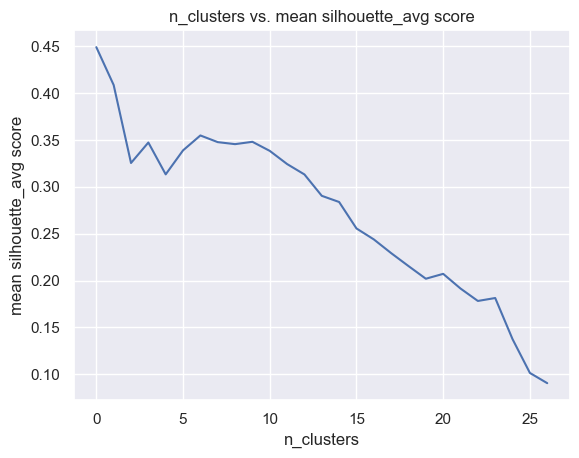

Best n_clusters value: 2


In [12]:
mean_silhouette_scores, best_n_clusters = evaluate_n_clusters(df=df, title='Paper Towns', start_clusters=2, end_clusters=(len(df)-1), num_iterations=20)
print("Best n_clusters value:", best_n_clusters)

In [13]:
# Call get_recommendations function and suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
df_recommended_clustering, score = get_recommendations(df=df, title='Paper Towns', n_clusters=best_n_clusters)
warnings.resetwarnings()
df_recommended_clustering.head()

,Titles,Authors,Genres,Blurbs,Book URLs,Book Ratings,Num Ratings,Num Reviews,sim_scores
1,The Catcher in the Rye,J.D. Salinger,"[Classics, Fiction, Young Adult, Literature, S...",It's Christmas time and Holden Caulfield has j...,https://www.goodreads.com/book/show/5107.The_C...,12.923771,3.691262,1.417087,1.683364
2,Where the Crawdads Sing,Delia Owens,"[Fiction, Historical Fiction, Mystery, Romance...","For years, rumors of the “Marsh Girl” haunted ...",https://www.goodreads.com/book/show/36809135-w...,14.930357,3.052899,3.404493,2.311689
3,All the Light We Cannot See,Anthony Doerr,"[Historical Fiction, Fiction, Historical, War,...",Marie-Laure lives in Paris near the Museum of ...,https://www.goodreads.com/book/show/18143977-a...,14.692287,1.695633,1.762355,1.063347
5,The Seven Husbands of Evelyn Hugo,Taylor Jenkins Reid,"[Fiction, Romance, Historical Fiction, LGBT, C...",Aging and reclusive Hollywood movie icon Evely...,https://www.goodreads.com/book/show/32620332-t...,15.066396,2.948836,4.326169,1.605721
9,People We Meet on Vacation,Emily Henry,"[Romance, Fiction, Contemporary, Contemporary ...",Two best friends. Ten summer trips. One last c...,https://www.goodreads.com/book/show/54985743-p...,13.229861,1.135374,1.727731,1.607310


# Discussion

The resulting code from our project allows us to recommend books to users given a genre, keyword or book. In our project, we explored a couple of different methods of recommending books to the user based on the information that the user wanted to give to us. Some of our functions that output a list of book recommendations are not original concepts– many popular book catalog websites such as Goodreads provide resources so that users are able to filter and provide new book recommendations to users based on data about their likes and dislikes. However, we don’t have knowledge of the method behind the recommendation of these books, or even if the process is done using math and data science methods. 
Our system primarily operates on a content-based recommendation system, using the details of the books to provide a suggestion. It is highly likely that the book recommendation system used by Goodreads and other book catalog websites is largely done by a collaborative recommendation system, in which users with similar preferences also liked a given book. Since we do not have this database of user information, our model is lacking on this front. Another aspect our model may fail upon is through sentiment analysis of blurbs. At the moment, our model operates on mere similarity of words or keywords within the book description. More language processing methods may allow for more accurate recommendations. 
Some additional factors that we could have added to make our recommendation system more accurate and nuanced are as follows:

- Taking into account a user's reading history including genres or authors previously enjoyed.
- Using data on a user’s non-reading interests such as music listening history, movies they’ve enjoyed, places they have traveled to/hope to travel to.
- Having the user input factors that influenced their enjoyment of the book they read.
- Allowing a user to input multiple books they enjoyed, or possibly an entire bookshelf of their favorite reads
